In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import os

from importlib import reload
import utils
from scipy import stats

In [2]:
level = 'sub'
ndims = 3
fs = 12
dpi = 96
KBINS_NO = 27

Cmap='plasma'
s = 30
sample = 'D2'
smcolumns = ['PCA 1','PCA 2','N','Density','Centrality']
crcolumns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr', 'spearson', 'ppearson', 'sspearman', 'pspearman']
rtkw = dict(ha='right', va='bottom', c='navy', bbox=dict(facecolor='cornsilk', alpha=0.75, boxstyle=mpl.patches.BoxStyle("Square", pad=0.05)))

wsrc = '..' + os.sep + 'cell_dams' + os.sep
nsrc = '..' + os.sep + 'nuclear_mask' + os.sep
ksrc = '..' + os.sep + 'kde' + os.sep + sample + os.sep
psrc = '..' + os.sep + 'geometry' + os.sep + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
gsrc = '..' + os.sep + level + 'level' + os.sep + sample + os.sep

k = 0
vs = ['' for _ in range( len(smcolumns)*( len(smcolumns) - 1)//2) ]
for i in range(len(smcolumns)-1):
    for j in range(i+1, len(smcolumns)):
        vs[k] = '{}-vs-{}'.format(smcolumns[i] , smcolumns[j] )
        k += 1
print(vs)

['PCA 1-vs-PCA 2', 'PCA 1-vs-N', 'PCA 1-vs-Density', 'PCA 1-vs-Centrality', 'PCA 2-vs-N', 'PCA 2-vs-Density', 'PCA 2-vs-Centrality', 'N-vs-Density', 'N-vs-Centrality', 'Density-vs-Centrality']


In [4]:
corrfiles = sorted( glob(isrc + '*'+level+'level/PI_scale*_corr_summary.csv') )
corrs = [None for _ in range(len(corrfiles))]
for i in range(len(corrs)):
    corrs[i] = pd.read_csv(corrfiles[i], index_col='Comparison')

print(corrs[0].shape)
print(corrs[0].index)
print(corrs[0].columns)

(36, 10)
Index(['PC 1-vs-PC 2', 'PC 1-vs-N', 'PC 1-vs-Density', 'PC 1-vs-N(05G203100)',
       'PC 1-vs-X', 'PC 1-vs-Y', 'PC 1-vs-Cell Size', 'PC 1-vs-Eccentricity',
       'PC 2-vs-N', 'PC 2-vs-Density', 'PC 2-vs-N(05G203100)', 'PC 2-vs-X',
       'PC 2-vs-Y', 'PC 2-vs-Cell Size', 'PC 2-vs-Eccentricity',
       'N-vs-Density', 'N-vs-N(05G203100)', 'N-vs-X', 'N-vs-Y',
       'N-vs-Cell Size', 'N-vs-Eccentricity', 'Density-vs-N(05G203100)',
       'Density-vs-X', 'Density-vs-Y', 'Density-vs-Cell Size',
       'Density-vs-Eccentricity', 'N(05G203100)-vs-X', 'N(05G203100)-vs-Y',
       'N(05G203100)-vs-Cell Size', 'N(05G203100)-vs-Eccentricity', 'X-vs-Y',
       'X-vs-Cell Size', 'X-vs-Eccentricity', 'Y-vs-Cell Size',
       'Y-vs-Eccentricity', 'Cell Size-vs-Eccentricity'],
      dtype='object', name='Comparison')
Index(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr',
       'spearson', 'ppearson', 'sspearman', 'pspearman'],
      dtype='object')


In [25]:
c = ['spearson','ppearson','sspearman','pspearman']
meta = dict()
for cname in cnames:
    for comp in ['Eccentricity', 'N(05G203100)']:
        key = cname + '-vs-' + comp
        meta[key] = pd.DataFrame(index=range(len(corrfiles)), columns=['gene', 'bw', 'scale'] + c + ['apearson', 'aspearman'])
        for i in range(len(corrs)):
            p,b = os.path.split(corrfiles[i])
            gene, bw, _ = p.split(os.sep)[-1].split('_')
            bw = int(bw[2:])
            scale = int(b.split('scale')[1].split('_')[0])
            meta[key].loc[i, ['gene','bw','scale'] ] = gene, bw, scale
            meta[key].loc[i, c] = corrs[i].loc[key, c ].values
        meta[key]['apearson'] = meta[key]['spearson'].abs()
        meta[key]['aspearman'] = meta[key]['sspearman'].abs()

In [26]:
key = 'PC 1-vs-Eccentricity'
print(key)
summary = pd.DataFrame(index = meta[key]['gene'].unique(), columns = ['bw','scale'] + c)
for gene in summary.index:
    foo = meta[key][ (meta[key]['gene'] == gene) & (meta[key]['bw'] > 10)].sort_values(by='aspearman', ascending=False).iloc[0]
    summary.loc[gene, ['bw','scale'] + c] = foo[['bw','scale'] + c]
summary

PC 1-vs-Eccentricity


,bw,scale,spearson,ppearson,sspearman,pspearman
01G164600,15,24,-0.120472,0.059713,-0.121775,0.056985
05G092200,15,48,0.394581,0.0,0.38075,0.0
05G203100,15,40,-0.13127,0.005766,-0.163983,0.000546
05G216000,20,40,-0.197333,0.0,-0.208798,0.0
12G027400,15,48,-0.103649,0.001673,-0.120962,0.000241
15G210100,30,48,-0.066203,0.045874,-0.085436,0.009924
17G185800,15,8,0.171813,0.0,0.162543,0.000001
17G195900,25,16,0.531839,0.0,0.573112,0.0
BAC45727,30,48,-0.188808,0.0,-0.214549,0.0
BAC47034,20,16,-0.256658,0.0,-0.266103,0.0


In [8]:
key = 'PC 1-vs-N(05G203100)'
print(key)
summary = pd.DataFrame(index = meta[key]['gene'].unique(), columns = ['bw','scale'] + c)
for gene in summary.index:
    foo = meta[key][ (meta[key]['gene'] == gene) & (meta[key]['bw'] > 10)].sort_values(by='aspearman', ascending=False).iloc[0]
    summary.loc[gene, ['bw','scale'] + c] = foo[['bw','scale'] + c]
summary

PC 1-vs-N(05G203100)


,bw,scale,spearson,ppearson,sspearman,pspearman
01G164600,30,48,-0.005582,0.930733,0.154077,0.015788
05G092200,15,8,0.151708,0.000004,0.145364,0.00001
05G203100,15,8,0.904319,0.0,0.895361,0.0
05G216000,15,8,0.198476,0.0,0.1997,0.0
12G027400,25,8,0.248808,0.0,0.317669,0.0
15G210100,20,48,0.102117,0.00204,0.182029,0.0
17G185800,20,48,0.066186,0.046412,0.145026,0.000012
17G195900,15,16,0.050186,0.128651,0.165851,0.0
BAC45727,15,24,0.150461,0.000005,0.216993,0.0
BAC47034,15,8,0.136833,0.000032,0.171169,0.0


In [29]:
key = 'PC 2-vs-N(05G203100)'
print(key)
summary = pd.DataFrame(index = meta[key]['gene'].unique(), columns = ['bw','scale'] + c)
for gene in summary.index:
    foo = meta[key][ (meta[key]['gene'] == gene) & (meta[key]['bw'] > 10)].sort_values(by='aspearman', ascending=False).iloc[0]
    summary.loc[gene, ['bw','scale'] + c] = foo[['bw','scale'] + c]
summary

PC 2-vs-N(05G203100)


,bw,scale,spearson,ppearson,sspearman,pspearman
01G164600,15,16,0.038028,0.553585,0.11191,0.080429
05G092200,15,8,0.017,0.606969,-0.078364,0.017562
05G203100,20,40,0.473746,0.0,0.526481,0.0
05G216000,15,48,0.106613,0.00136,0.125014,0.00017
12G027400,30,40,0.240961,0.0,0.261089,0.0
15G210100,20,8,-0.062357,0.060063,-0.150417,0.000005
17G185800,30,8,-0.012151,0.714921,-0.100499,0.002458
17G195900,20,8,-0.116828,0.00039,-0.153242,0.000003
BAC45727,15,8,0.008037,0.808076,-0.110472,0.000811
BAC47034,15,16,0.099218,0.002617,0.161471,0.000001


In [30]:
key = 'PC 2-vs-Eccentricity'
print(key)
summary = pd.DataFrame(index = meta[key]['gene'].unique(), columns = ['bw','scale'] + c)
for gene in summary.index:
    foo = meta[key][ (meta[key]['gene'] == gene) & (meta[key]['bw'] > 10)].sort_values(by='aspearman', ascending=False).iloc[0]
    summary.loc[gene, ['bw','scale'] + c] = foo[['bw','scale'] + c]
summary

PC 2-vs-Eccentricity


,bw,scale,spearson,ppearson,sspearman,pspearman
01G164600,15,8,-0.116498,0.068705,-0.203972,0.001327
05G092200,25,8,0.332353,0.0,0.331335,0.0
05G203100,25,32,0.056742,0.23438,0.125894,0.008125
05G216000,15,8,-0.208621,0.0,-0.170509,0.0
12G027400,20,40,0.153235,0.000003,0.168017,0.0
15G210100,15,48,0.23687,0.0,0.239256,0.0
17G185800,15,48,0.153011,0.000004,0.179343,0.0
17G195900,15,24,0.576372,0.0,0.606246,0.0
BAC45727,15,8,-0.187766,0.0,-0.195629,0.0
BAC47034,20,8,0.372306,0.0,0.3673,0.0


# Other 

In [3]:
gene_list = ['Glyma.05G092200','Glyma.05G216000','Glyma.12G027400','Glyma.15G210100','Glyma.17G185800','Glyma.17G195900']
gene_list = [x.replace('.','_').upper() for x in gene_list]
dfmeta = pd.DataFrame(index=gene_list)
dfmeta['ex_nuclei'] = ['','','', '_w_nucleus','','']
dfmeta['bw'] = [25,15,20,15,15,15]
dfmeta['SCALE'] = [16,8,40,48,48,24]
dfmeta['color'] = ['#cc79a7', '#009e73', '#0072b2', '#d55e00', '#e69f00', '#56b4e9']

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)
for c in smcolumns:
    dfmeta[c+'_min'] = 0.
    dfmeta[c+'_max'] = 0.
dfmeta

,ex_nuclei,bw,SCALE,color,PCA 1_min,PCA 1_max,PCA 2_min,PCA 2_max,N_min,N_max,Density_min,Density_max,Centrality_min,Centrality_max
GLYMA_05G092200,,25,16,#cc79a7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLYMA_05G216000,,15,8,#009e73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLYMA_12G027400,,20,40,#0072b2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLYMA_15G210100,_w_nucleus,15,48,#d55e00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLYMA_17G185800,,15,48,#e69f00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLYMA_17G195900,,15,24,#56b4e9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df = dict(zip(gene_list, [pd.DataFrame() for _ in gene_list]))
corr = dict(zip(gene_list, [pd.DataFrame() for _ in gene_list]))

In [6]:
gene = gene_list[0]
transcell = pd.read_csv(ksrc+sample+'_transcells_metadata'+ dfmeta.loc[gene, 'ex_nuclei'] +'.csv', index_col='gene').rename(columns=int)

bw, SCALE = dfmeta.loc[gene, ['bw', 'SCALE']].values
centrality = pd.read_csv(psrc + '{}/{}_bins_bw{}_S{}_peripherality.csv'.format(gene, KBINS_NO-1, bw, SCALE))

bname = isrc + '{}_bw{}_{}level'.format(gene.replace('GLYMA_',''), bw, level) + os.sep + 'PI_scale{}_'.format(SCALE)
Bname = gene.replace('_','.').title() + ' PIs: {}level persistence.'.format(level.title())
print(bname, Bname, sep='\n')

embedding = pd.read_csv(bname + 'pca.csv')
zero_val = embedding.iloc[-1, 2:].values
zs = [0, 0, zero_val[0], zero_val[1]]
embedding = embedding.iloc[:-1]

gcells = transcell.loc[gene,Cells][transcell.loc[gene,Cells] > 0].index
df[gene].index = gcells
for i in range(2):
    df[gene][smcolumns[i]] = embedding.iloc[:, i+2].values
i+=1
df[gene][smcolumns[i]] = transcell.loc[gene, gcells]; i+=1
df[gene][smcolumns[i]] = transcell.loc[gene, gcells]/metacell.loc[gcells, 'cyto_area']; i+=1
#df[gene][smcolumns[i]] = metaecc.loc[gcells, 'eccentricity']; i+=1
df[gene][smcolumns[i]] = centrality[gene + '_-_m'].values; i+=1

dfmin = df[gene].min()
dfmax = df[gene].max()
for c in dfmin.index:
    dfmeta.loc[gene, c+'_min'] = dfmin[c]
    dfmeta.loc[gene, c+'_max'] = dfmax[c]

df[gene]

../infected_focus_summer24/D2/05G092200_bw25_sublevel/PI_scale16_
Glyma.05G092200 PIs: Sublevel persistence.


,PCA 1,PCA 2,N,Density,Centrality
169,-0.310433,1.639723,456,0.004270,-0.475850
188,4.613187,0.891842,1687,0.007122,0.013184
199,1.945062,-0.327091,637,0.006221,-0.800542
209,-0.052353,-1.599265,503,0.011788,-0.222211
224,-0.408097,-1.080498,465,0.005884,-0.281973
...,...,...,...,...,...
2536,-1.012375,0.376259,417,0.006215,-0.143472
2548,-0.699816,-0.299940,428,0.006259,-0.197332
2552,1.249713,-1.348994,711,0.007167,-0.522598
2573,-0.683212,2.048098,345,0.004463,-0.451892


In [8]:
corr[gene] = pd.DataFrame(index=vs, columns=crcolumns)

for idx in corr[gene].index:
    x,y = df[gene].loc[ :, idx.split('-vs-') ].T.values
    corr[gene].loc[idx, ['sspearman', 'pspearman'] ] = stats.spearmanr(x,y)
    corr[gene].loc[idx, ['spearson', 'ppearson'] ] = stats.pearsonr(x,y)
    c = stats.linregress(x,y)
    corr[gene].loc[idx, ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']] = c
    corr[gene].loc[idx, 'intercept_stderr'] = c.intercept_stderr

corr[gene]

,slope,intercept,rvalue,pvalue,stderr,intercept_stderr,spearson,ppearson,sspearman,pspearman
PCA 1-vs-PCA 2,-0.003009,0.001975,-0.003955,0.904747,0.025135,0.0329,-0.003955,0.904747,0.014202,0.667385
PCA 1-vs-N,150.857711,464.069149,0.771054,0.0,4.116394,5.388142,0.771054,0.0,0.802916,0.0
PCA 1-vs-Density,0.000313,0.006131,0.15554,0.000002,0.000066,0.000086,0.15554,0.000002,0.284362,0.0
PCA 1-vs-Centrality,-0.138406,-0.385408,-0.702846,0.0,0.004628,0.006058,-0.702846,0.0,-0.726618,0.0
PCA 2-vs-N,-36.620779,478.695664,-0.142387,0.000015,8.411264,8.352668,-0.142387,0.000015,-0.099227,0.002614
PCA 2-vs-Density,-0.001708,0.006164,-0.646568,0.0,0.000067,0.000066,-0.646568,0.0,-0.657207,0.0
PCA 2-vs-Centrality,-0.036012,-0.39871,-0.139118,0.000023,0.00847,0.008411,-0.139118,0.000023,-0.181999,0.0
N-vs-Density,0.000003,0.004819,0.272993,0.0,0.0,0.000177,0.272993,0.0,0.321954,0.0
N-vs-Centrality,-0.000497,-0.160661,-0.494267,0.0,0.000029,0.015684,-0.494267,0.0,-0.579148,0.0
Density-vs-Centrality,24.095744,-0.547221,0.245911,0.0,3.138119,0.021013,0.245911,0.0,0.154935,0.000002


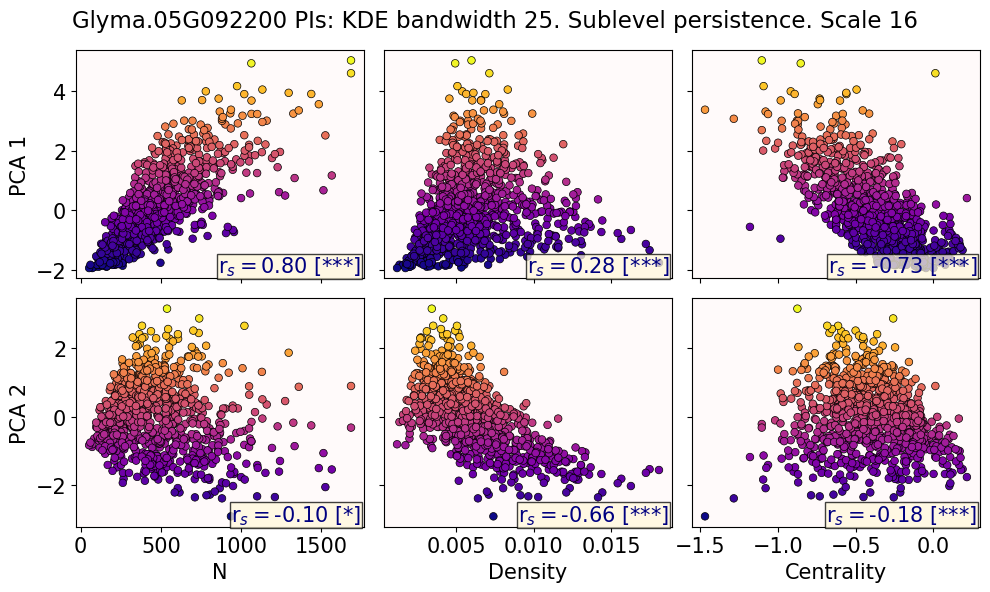

In [23]:
fig, ax = plt.subplots(2, len(smcolumns)-2, figsize=(10,6), sharex=False, sharey=False)

for j in range(ax.shape[1]):
    
    x = df[gene][smcolumns[j+2]]
    ax[0,j].tick_params(bottom=True, labelbottom=False)
    ax[1,j].set_xlabel(smcolumns[j+2], fontsize=fs)
    
    for i in range(ax.shape[0]):

        y = df[gene][smcolumns[i]]
            
        ax[i,j].scatter(x, y, c=y,  marker='o', cmap=Cmap, s=s,
                        edgecolor='k', linewidth=0.5, zorder=3)
        ax[i,j].set_facecolor('snow')
        ax[i,j].tick_params(labelsize=fs)
        
        r,p = corr[gene].loc[smcolumns[i] + '-vs-' + smcolumns[j+2], ['sspearman', 'pspearman'] ]
        ll = 'r$_s = ${:.2f} [{}]'.format(r, utils.star_signif(p, mx=3))
        ax[i,j].text(0.99,0, ll, transform=ax[i,j].transAxes, fontsize=fs, **rtkw)

for i in range(ax.shape[0]):
    ax[i,0].set_ylabel(smcolumns[i], fontsize=fs)
    for j in range(1,ax.shape[1]):
        ax[i,j].tick_params(labelleft=False)
        
fig.suptitle(Bname, fontsize=1.1*fs)
fig.tight_layout()
plt.savefig(bname + 'spatial_corr.png', dpi=dpi, format='png', bbox_inches='tight')

# All together

In [7]:
df = dict(zip(gene_list, [pd.DataFrame() for _ in gene_list]))
corr = dict(zip(gene_list, [pd.DataFrame() for _ in gene_list]))

for gene in gene_list:
    transcell = pd.read_csv(ksrc+sample+'_transcells_metadata'+ dfmeta.loc[gene, 'ex_nuclei'] +'.csv', index_col='gene').rename(columns=int)
    bw, SCALE = dfmeta.loc[gene, ['bw', 'SCALE']].values
    centrality = pd.read_csv(psrc + '{}/{}_bins_bw{}_S{}_peripherality.csv'.format(gene, KBINS_NO-1, bw, SCALE))
    
    bname = isrc + '{}_bw{}_{}level'.format(gene.replace('GLYMA_',''), bw, level) + os.sep + 'PI_scale{}_'.format(SCALE)
    Bname = gene.replace('_','.').title() + ' PIs: {}level persistence.'.format(level.title())
    print(bname, Bname, sep='\n')
    
    embedding = pd.read_csv(bname + 'pca.csv')
    zero_val = embedding.iloc[-1, 2:].values
    zs = [0, 0, zero_val[0], zero_val[1]]
    embedding = embedding.iloc[:-1]
    
    gcells = transcell.loc[gene,Cells][transcell.loc[gene,Cells] > 0].index
    df[gene].index = gcells
    for i in range(2):
        df[gene][smcolumns[i]] = embedding.iloc[:, i+2].values
    i+=1
    df[gene][smcolumns[i]] = transcell.loc[gene, gcells]; i+=1
    df[gene][smcolumns[i]] = transcell.loc[gene, gcells]/metacell.loc[gcells, 'cyto_area']; i+=1
    df[gene][smcolumns[i]] = centrality[gene + '_-_m'].values; i+=1
    
    dfmin = df[gene].min()
    dfmax = df[gene].max()
    for c in dfmin.index:
        dfmeta.loc[gene, c+'_min'] = dfmin[c]
        dfmeta.loc[gene, c+'_max'] = dfmax[c]
    
    corr[gene] = pd.DataFrame(index=vs, columns=crcolumns)
    for idx in corr[gene].index:
        x,y = df[gene].loc[ :, idx.split('-vs-') ].T.values
        corr[gene].loc[idx, ['sspearman', 'pspearman'] ] = stats.spearmanr(x,y)
        corr[gene].loc[idx, ['spearson', 'ppearson'] ] = stats.pearsonr(x,y)
        c = stats.linregress(x,y)
        corr[gene].loc[idx, ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']] = c
        corr[gene].loc[idx, 'intercept_stderr'] = c.intercept_stderr
    
    fig, ax = plt.subplots(2, len(smcolumns)-2, figsize=(10,6), sharex=False, sharey=False)
    
    for j in range(ax.shape[1]):
        
        x = df[gene][smcolumns[j+2]]
        ax[0,j].tick_params(bottom=True, labelbottom=False)
        ax[1,j].set_xlabel(smcolumns[j+2], fontsize=fs)
        
        for i in range(ax.shape[0]):
    
            y = df[gene][smcolumns[i]]
                
            ax[i,j].scatter(x, y, c=y,  marker='o', cmap=Cmap, s=s,
                            edgecolor='k', linewidth=0.5, zorder=3)
            ax[i,j].set_facecolor('snow')
            ax[i,j].tick_params(labelsize=fs)
            
            r,p = corr[gene].loc[smcolumns[i] + '-vs-' + smcolumns[j+2], ['sspearman', 'pspearman'] ]
            ll = 'r$_s = ${:.2f} [{}]'.format(r, utils.star_signif(p, mx=3))
            ax[i,j].text(0.99,0, ll, transform=ax[i,j].transAxes, fontsize=fs, **rtkw)
    
    for i in range(ax.shape[0]):
        ax[i,0].set_ylabel(smcolumns[i], fontsize=fs)
        for j in range(1,ax.shape[1]):
            ax[i,j].tick_params(labelleft=False)
            
    fig.suptitle(Bname, fontsize=1.1*fs)
    fig.tight_layout()
    plt.savefig(bname + 'spatial_corr.png', dpi=dpi, format='png', bbox_inches='tight')
    print(bname + 'spatial_corr.png')
    plt.close()

../infected_focus_summer24/D2/05G092200_bw25_sublevel/PI_scale16_
Glyma.05G092200 PIs: Sublevel persistence.
../infected_focus_summer24/D2/05G092200_bw25_sublevel/PI_scale16_spatial_corr.png
../infected_focus_summer24/D2/05G216000_bw15_sublevel/PI_scale8_
Glyma.05G216000 PIs: Sublevel persistence.
../infected_focus_summer24/D2/05G216000_bw15_sublevel/PI_scale8_spatial_corr.png
../infected_focus_summer24/D2/12G027400_bw20_sublevel/PI_scale40_
Glyma.12G027400 PIs: Sublevel persistence.
../infected_focus_summer24/D2/12G027400_bw20_sublevel/PI_scale40_spatial_corr.png
../infected_focus_summer24/D2/15G210100_bw15_sublevel/PI_scale48_
Glyma.15G210100 PIs: Sublevel persistence.
../infected_focus_summer24/D2/15G210100_bw15_sublevel/PI_scale48_spatial_corr.png
../infected_focus_summer24/D2/17G185800_bw15_sublevel/PI_scale48_
Glyma.17G185800 PIs: Sublevel persistence.
../infected_focus_summer24/D2/17G185800_bw15_sublevel/PI_scale48_spatial_corr.png
../infected_focus_summer24/D2/17G195900_bw15_su

# t-tests

In [4]:
from scipy import ndimage
import tifffile as tf

In [5]:
vol = 'area'
nuclei_mask_cutoff = 1
label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')
wcoords = np.loadtxt(ksrc + sample + '_icoords.csv', delimiter=',', dtype=int)
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

Detected 2937 cells
Detected 1365 nuclei


In [6]:
exclude_nuclei = False

if exclude_nuclei:
    filenameb = '..' + os.sep + 'translocs' + os.sep + sample + os.sep + 'location_corrected_D2_-_{}.csv'
    ex_nuclei = ''
    pdkw = {'header':None, 'names':['X', 'Y', 'Z']}
else:
    filenameb = '..' + os.sep + 'Bacteria Info for Erik' + os.sep + '{}_v2.txt'
    ex_nuclei = '_w_nucleus'
    pdkw = {'sep':'\t'}

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata' + ex_nuclei + '.csv', index_col='gene').rename(columns=int)
transcriptomes = np.asarray(transcell.index, dtype=str)

translocs = dict()
for gene in transcriptomes:
    filename = filenameb.format(gene)
    translocs[gene] = pd.read_csv(filename, **pdkw)
    translocs[gene]['cidx'] = label[ translocs[gene]['Y'], translocs[gene]['X'] ]
    translocs[gene]['nidx'] =  lnuc[ translocs[gene]['Y'], translocs[gene]['X'] ]
tlocs = pd.concat(translocs)

In [173]:
volkeys = ['area', 'volume']
gcell = np.intersect1d( Cells, metacell[metacell['number_nuclei'] == 1].index)
density = dict(zip(volkeys, [dict() for _ in range(len(volkeys))]))
for key in density:
    for gene in transcriptomes[10:]:
        density[key][gene] = pd.DataFrame(0, index=gcell, columns=['Ncyto', 'Nnuclei', 'cyto', 'nuclei'], dtype=float).astype({'Ncyto':int, 'Nnuclei':int})

In [175]:
for gene in density[volkeys[0]]:
    for cidx in gcell:
        coords = translocs[gene][ translocs[gene]['cidx'] == cidx ]
        for key in volkeys:
            for c in ['cyto', 'nuclei']:
                density[key][gene].loc[cidx,'N'+c] = len(coords[coords['L'] == c[0]])
                density[key][gene].loc[cidx, c] = len(coords[coords['L'] == c[0]])/metacell.loc[cidx, c + '_' + key]

In [163]:
ttest = dict(zip(volkeys, [pd.DataFrame(1., index=density[key].keys(), columns=['stat', 'pvalue', 'df', 'bh', 'by']) for _ in range(len(volkeys))]))
for key in ttest:
    for gene in ttest[key].index:
        t_test = stats.ttest_rel(*density[key][gene].T.values)
        ttest[key].loc[gene] = [t_test.statistic, t_test.pvalue, t_test.df,1,1]
    ttest[key] = ttest[key].loc[~pd.isna(ttest[key]['pvalue'])]
    for method in ['bh','by']:
        ttest[key][method] = stats.false_discovery_control(ttest[key]['pvalue'].values, method=method)

In [165]:
ttest[key][ttest[key]['bh'] < 0.01]

,stat,pvalue,df,bh,by
GLYMA_01G156200,3.186137,1.579185e-03,331.0,7.048528e-03,3.491121e-02
GLYMA_01G164600,-7.189481,4.355404e-12,331.0,6.881539e-11,3.408412e-10
GLYMA_02G003700,3.219456,1.411616e-03,331.0,7.048528e-03,3.491121e-02
GLYMA_03G079500,6.006514,4.991134e-09,331.0,5.632851e-08,2.789939e-07
GLYMA_05G092200,12.786599,1.063786e-30,331.0,2.801304e-29,1.387480e-28
GLYMA_06G002000,-5.229855,3.014253e-07,331.0,2.381260e-06,1.179433e-05
GLYMA_09G127000,-3.199055,1.512144e-03,331.0,7.048528e-03,3.491121e-02
GLYMA_10G229400,-3.181113,1.605994e-03,331.0,7.048528e-03,3.491121e-02
GLYMA_11G078300,-5.013069,8.745673e-07,331.0,6.280983e-06,3.110958e-05
GLYMA_11G221200,-4.553708,7.417489e-06,331.0,4.883181e-05,2.418629e-04


In [253]:
ctrans = pd.Series()
for gene in density[key]:
    foo = density[key][gene][(density[key][gene]['Ncyto'] > 0) & (density[key][gene]['Nnuclei'] > 0)]
    if len(foo) > 0:
        ctrans[gene] = len(foo)

ctrans = ctrans[ctrans > 0.05*len(gcell)]
ctrans

GLYMA_01G164600     26
GLYMA_05G092200    171
GLYMA_05G203100     20
GLYMA_05G216000     76
GLYMA_06G090100     25
GLYMA_09G127000     38
GLYMA_12G027400    198
GLYMA_15G210100    216
GLYMA_16G039800     33
GLYMA_17G185800     19
GLYMA_17G195900    308
dtype: int64

In [231]:
gene = 'GLYMA_05G216000'
#gene = 'GLYMA_15G210100'
#gene = 'GLYMA_17G195900'
dd = density[key][gene][(density[key][gene]['Ncyto'] > 0) & (density[key][gene]['Nnuclei'] > 0)]
print(len(dd))
np.log10((dd['nuclei']/dd['cyto']).values)

76


array([ 0.03050721,  0.4541595 ,  0.35587546,  0.38224271,  0.34802991,
        0.78621046,  0.54745719,  0.10516592,  0.3727683 ,  0.04991854,
        0.93546308,  0.16645838,  0.26275996,  0.56498286,  0.72880758,
        0.22578776,  0.29482128,  0.2716552 ,  0.67611078,  0.57866201,
        0.40064195,  1.15548319,  0.76108678,  0.42222137,  0.19424736,
        0.57188358,  1.18723459,  0.8042349 ,  0.59080858,  1.19660454,
        0.67991241,  0.12457897,  0.57194714,  0.1950621 ,  0.22867332,
        0.01302318, -0.05861339,  0.76896158,  0.71870968,  1.19356064,
        0.37910541,  0.13318361,  0.17971499,  0.24940341,  0.64160327,
        0.92917309,  0.91010087,  1.55434914,  0.35978753,  0.48782013,
        0.32122491,  0.37176291,  0.3811866 ,  0.55250747,  0.76512818,
        0.56470164,  0.1345908 ,  0.62218692,  0.07092783,  0.30562456,
        0.63613014, -0.06607158,  0.27486578,  0.35400935,  0.416633  ,
        0.93111862,  0.83601668,  0.51941276,  1.0839306 ,  0.24

In [255]:
ratios = dict(zip(volkeys,[dict() for _ in range(len(volkeys))]))
for key in ratios:
    for gene in ctrans.index:
        dd = density[key][gene][(density[key][gene]['Ncyto'] > 0) & (density[key][gene]['Nnuclei'] > 0)]
        ratios[key][gene] = np.log10((dd['nuclei']/dd['cyto']).values)

In [286]:
pvals = dict(zip(volkeys,[pd.DataFrame(-1., index=ctrans.index, columns=ctrans.index) for _ in range(len(volkeys))]))
for key in pvals:
    for i in range(len(ctrans)-1):
        for j in range(i+1, len(ctrans)):
            pvals[key].iloc[i,j] = stats.ttest_ind(ratios[key][ctrans.index[i]], ratios[key][ctrans.index[j]]).pvalue

bhpvals = dict(zip(volkeys,[pd.DataFrame(1., index=ctrans.index, columns=ctrans.index) for _ in range(len(volkeys))]))
for key in pvals:
    pv = pvals[key].values.ravel().copy()
    pv = stats.false_discovery_control(pv[pv >= 0], method='bh')
    idx = 0
    for i in range(len(ctrans)-1):
        for j in range(i+1, len(ctrans)):
            bhpvals[key].iloc[i,j] = pv[idx]
            bhpvals[key].iloc[j,i] = pv[idx]
            idx += 1

bypvals = dict(zip(volkeys,[pd.DataFrame(1., index=ctrans.index, columns=ctrans.index) for _ in range(len(volkeys))]))
for key in pvals:
    pv = pvals[key].values.ravel().copy()
    pv = stats.false_discovery_control(pv[pv >= 0], method='by')
    idx = 0
    for i in range(len(ctrans)-1):
        for j in range(i+1, len(ctrans)):
            bypvals[key].iloc[i,j] = pv[idx]
            bypvals[key].iloc[j,i] = pv[idx]
            idx += 1

In [280]:
pv = pvals[key].values.ravel()
stats.false_discovery_control(pv[pv >= 0], method='bh')

array([2.82760594e-047, 1.68085591e-010, 2.20357274e-030, 1.03518277e-008,
       1.53067003e-009, 5.95235493e-053, 3.75653342e-025, 6.42311419e-012,
       2.13424485e-017, 3.63721522e-021, 9.38315634e-015, 5.72635242e-030,
       9.83376809e-033, 8.35156593e-042, 2.39688936e-056, 7.10267194e-105,
       1.67763147e-029, 3.63570289e-013, 3.86926315e-054, 4.85386282e-002,
       1.12984083e-004, 6.09818636e-005, 3.04330136e-003, 1.14624855e-003,
       7.34455931e-002, 5.22140328e-001, 3.52682246e-001, 2.95951727e-016,
       1.95382564e-018, 4.76698861e-001, 3.69964409e-023, 3.85698744e-008,
       2.17288019e-001, 3.37678971e-001, 6.76530815e-001, 1.93082291e-026,
       1.71088247e-004, 2.85807106e-003, 3.30797473e-010, 4.92824538e-008,
       1.54526850e-031, 1.03094879e-004, 3.98202549e-003, 2.49168791e-009,
       3.17536184e-010, 2.99196195e-047, 4.71700527e-014, 5.44424820e-002,
       2.49816324e-002, 6.76530815e-001, 3.48082005e-006, 1.04196533e-018,
       1.85087121e-003, 4

In [291]:
bypvals[key]

,GLYMA_01G164600,GLYMA_05G092200,GLYMA_05G203100,GLYMA_05G216000,GLYMA_06G090100,GLYMA_09G127000,GLYMA_12G027400,GLYMA_15G210100,GLYMA_16G039800,GLYMA_17G185800,GLYMA_17G195900
GLYMA_01G164600,1.000000e+00,1.298893e-46,7.721200e-10,1.012236e-29,4.755228e-08,7.031305e-09,2.734281e-52,1.725606e-24,2.950530e-11,9.803893e-17,1.670796e-20
GLYMA_05G092200,1.298893e-46,1.000000e+00,4.310258e-14,2.630464e-29,4.517252e-32,3.836386e-41,1.101038e-55,3.262692e-104,7.706388e-29,1.670101e-12,1.777389e-53
GLYMA_05G203100,7.721200e-10,4.310258e-14,1.000000e+00,2.229676e-01,5.190051e-04,2.801270e-04,1.397975e-02,5.265421e-03,3.373806e-01,1.000000e+00,1.000000e+00
GLYMA_05G216000,1.012236e-29,2.630464e-29,2.229676e-01,1.000000e+00,1.359487e-15,8.975117e-18,1.000000e+00,1.699473e-22,1.771750e-07,9.981369e-01,1.000000e+00
GLYMA_06G090100,4.755228e-08,4.517252e-32,5.190051e-04,1.359487e-15,1.000000e+00,1.000000e+00,8.869452e-26,7.859131e-04,1.312887e-02,1.519555e-09,2.263845e-07
GLYMA_09G127000,7.031305e-09,3.836386e-41,2.801270e-04,8.975117e-18,1.000000e+00,1.000000e+00,7.098364e-31,4.735779e-04,1.829188e-02,1.144585e-08,1.458638e-09
GLYMA_12G027400,2.734281e-52,1.101038e-55,1.397975e-02,1.000000e+00,8.869452e-26,7.098364e-31,1.000000e+00,1.374391e-46,2.166809e-13,2.500877e-01,1.147559e-01
GLYMA_15G210100,1.725606e-24,3.262692e-104,5.265421e-03,1.699473e-22,7.859131e-04,4.735779e-04,1.374391e-46,1.000000e+00,1.000000e+00,1.598954e-05,4.786385e-18
GLYMA_16G039800,2.950530e-11,7.706388e-29,3.373806e-01,1.771750e-07,1.312887e-02,1.829188e-02,2.166809e-13,1.000000e+00,1.000000e+00,8.502185e-03,2.014881e-03
GLYMA_17G185800,9.803893e-17,1.670101e-12,1.000000e+00,9.981369e-01,1.519555e-09,1.144585e-08,2.500877e-01,1.598954e-05,8.502185e-03,1.000000e+00,1.000000e+00


In [110]:
gene = 'GLYMA_17G195900'
cidx = 169
c = 'cyto'

ttest = stats.ttest_rel(*density[key][gene].T.values)
ttest

TtestResult(statistic=-20.039637186598085, pvalue=4.661200023869701e-59, df=331)

In [57]:
vol = 'area'
density = pd.DataFrame(index = transcriptomes[10:], columns=['cyto', 'nuclei'])

for gene in density.index:
    for cidx in np.intersect1d( Cells, metacell[metacell['number_nuclei'] == 1].index):
        coords = translocs[gene][ translocs[gene]['cidx'] == cidx ]
        
        for c in density.columns:
            density.loc[gene, c] = len(coords[coords['L'] == c[0]])/metacell.loc[cidx, c + '_' + vol]
density

,cyto,nuclei
CYP93A1,0.0,0.0
G4DT,0.0,0.0
GLYMA_01G019200,0.0,0.0
GLYMA_01G156200,0.0,0.0
GLYMA_01G164600,0.00002,0.0
...,...,...
GLYMA_19G255500,0.0,0.0
GLYMA_20G054000,0.0,0.0
GLYMA_20G061300,0.0,0.0
GLYMA_20G135300,0.0,0.0


In [60]:
density0 = density.loc[~(density == 0).all(axis='columns')]

In [61]:
density0

,cyto,nuclei
GLYMA_01G164600,0.00002,0.0
GLYMA_01G187400,0.00001,0.0
GLYMA_05G092200,0.007157,0.006508
GLYMA_05G216000,0.000071,0.0
GLYMA_06G090100,0.00002,0.0
GLYMA_06G256000,0.00001,0.0
GLYMA_09G127000,0.00001,0.0
GLYMA_10G229400,0.0,0.001085
GLYMA_11G008000,0.00006,0.0
GLYMA_12G027400,0.000313,0.001085


0.031170483460559797

In [ ]:
transcell = pd.read_csv(ksrc+sample+'_transcells_metadata_w_nucleus.csv', index_col='gene').rename(columns=int)
Ns = transcell.loc[:, gcells]

In [63]:
metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')

In [48]:
stepsize = 3
exclude_nuclei = True

if exclude_nuclei:
    filenameb = '..' + os.sep + 'translocs' + os.sep + sample + os.sep + 'location_corrected_D2_-_{}.csv'
    ex_nuclei = ''
    pdkw = {'header':None, 'names':['X', 'Y', 'Z']}
else:
    filenameb = '..' + os.sep + 'Bacteria Info for Erik' + os.sep + '{}_v2.txt'
    ex_nuclei = '_w_nucleus'
    pdkw = {'sep':'\t'}

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata' + ex_nuclei + '.csv', index_col='gene').rename(columns=int)
transcriptomes = np.asarray(transcell.index, dtype=str)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection' + ex_nuclei + '.csv', transcriptomes, startval=0)

translocs = dict()
for key in transcriptomes:
    filename = filenameb.format(key)
    translocs[key] = pd.read_csv(filename, **pdkw)
    
tlocs = pd.concat(translocs)
zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

In [57]:
if 'BAC' in gene:
    geneprint = 'Bac.' + gene[3:]
    genename = gene
else:
    geneprint = 'Glyma.' + gene
    genename = 'GLYMA_' + gene
bw, SCALE = summary.loc[gene, ['bw', 'scale']].values.astype(int)
bname = isrc + '{}_bw{}_{}level'.format(gene, bw, level) + os.sep + 'PI_scale{}_'.format(SCALE)
Bname = geneprint + ' PIs: KDE bandwidth {}. {}level persistence. Scale {}'.format(bw, level.title(), SCALE)
print(bname, Bname, sep='\n')

../infected_focus_summer24/D2/BAC52602_bw15_sublevel/PI_scale8_
Bac.52602 PIs: KDE bandwidth 15. Sublevel persistence. Scale 8


In [54]:
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
embedding = pd.read_csv(bname + 'pca.csv')
zero_val = embedding.iloc[-1, 2:].values
zs = [0, 0, zero_val[0], zero_val[1]]
embedding = embedding.iloc[:-1]
pca = embedding.iloc[:,2:4].values

In [66]:
cmask = embedding['ndimage_ID'].copy()

summary0 = embedding.iloc[:, 1:4].copy().set_index('ndimage_ID')
density = transcell.loc[genename, cmask] / metacell.loc[cmask, 'cyto_area']
density.name = 'density'
NN = transcell.loc[genename, cmask].copy()
NN.name = 'N'
summary0 = summary0.join(pd.concat([NN, density], axis=1), how='outer').join(transcell.loc['GLYMA_05G203100', cmask] + 1)
summary0 = summary0.join(metacell.loc[cmask, ['ndimage_comX','ndimage_comY','cyto_area']], how='outer')
summary0.iloc[ pd.isna(summary0.iloc[:,0]).values , :2] = zero_val[:2]
summary0 = summary0.join(metaecc['eccentricity'].max() - metaecc.loc[cmask, 'eccentricity'])

summary0.columns = smcolumns
print(summary0.shape)
summary0.head()

(918, 9)


,PC 1,PC 2,N,Density,N(05G203100),X,Y,Cell Size,Eccentricity
ndimage_ID,,,,,,,,,
169,-0.260521,-0.247730,94,0.000880,4,7789.38,3043.66,106788,4745.936000
188,1.334498,-0.732867,167,0.000705,22,8140.11,3270.17,236885,4455.824132
199,0.999605,0.183603,203,0.001983,1,7409.04,3189.21,102388,4677.492017
209,-1.224072,-0.072569,29,0.000680,1,8798.15,3142.66,42671,4555.942172
224,-0.031961,-0.214672,96,0.001215,1,6297.28,3275.46,79031,4832.496197


In [67]:
x = summary0['PC 2']
y = summary0['Eccentricity']
stats.spearmanr(x,y)

SignificanceResult(statistic=-0.219029569167738, pvalue=1.9615828765844545e-11)

In [101]:
transcell[Cells].iloc[:10].T.describe()

gene,BAC45727,BAC46169,BAC47034,BAC47856,BAC48395,BAC51072,BAC51722,BAC52602,BAC52793,BAC52805
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,31.531590,1.063181,1788.593682,1.887800,2.883442,2.704793,0.311547,117.250545,2.364924,1.897603
std,20.124221,1.191727,1033.164432,2.009097,2.441134,2.427352,0.615058,63.086328,2.271331,1.746277
min,0.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,16.000000,0.000000,964.250000,0.000000,1.000000,1.000000,0.000000,71.000000,1.000000,1.000000
50%,27.000000,1.000000,1655.000000,1.000000,2.000000,2.000000,0.000000,108.000000,2.000000,1.000000
75%,44.000000,2.000000,2466.250000,3.000000,4.000000,4.000000,0.000000,157.000000,3.000000,3.000000
max,113.000000,7.000000,5641.000000,17.000000,14.000000,14.000000,3.000000,409.000000,20.000000,9.000000
